## Background

When it comes to music, our brain engages in complex creative processes
that involve combining elements such as rhythm, pitch, and timbre.
Today many musicians spend a significant time recording, editing, and arranging music.
This project aims to ease music generation from a sample track. The musicican can hum his melody
into his microphone, and the system will generate complementary track.

The first step in generating similar music is to analyze the style.
Style includes all elements of music. i.e rhythm, pitch and timbre.
Firstly, we detect the pitches, which helps us understand the underlying melody.
Firstly, lets define pitch.

### Musical notation

Music notation is any system used to visually represent aurally perceived music. Lets take a look at a subset of this notation which deals with pitch.

The chromatic scale is a set of twelve pitches used in music. 

$$C \;\; C\# \;\; D \;\; D\# \;\; E \;\; F \;\; F\# \;\; G \;\; G\# \;\; A \;\; A\# \;\; B$$

These notes are cyclic, therefore C comes after B. A number is used to represent the octave.
The interval between any two subsequenct notes is a semi-tone.

A4 is usually used as the reference note with frequency 440Hz. A5 is thus an octave higher (880Hz).

### MIDI

MIDI (Musical Instrument Digital Interface) is a standard interface recognized by several musical instruments and processors. In MIDI the middle C note (C4) is represented with the number 60. A note that is a semitone higher is represented by a number one higher than the previous. Similary, a note that is a semitone lower is represented by a number one less than the previous. For A4, which is 9 semitones higher than C4, the midi representation is 69.


### Mapping frequency to musical notation

We can leverage MIDI to convert frequency to musical notation.

The function to convert a frequency to MIDI number is:

$$  M(f) = 69 + 12 \cdot \log_2{\frac{x}{440}} $$


Then we can map the MIDI number to notation from the definition of MIDI.

In [6]:
import math


class Note:
    def __init__(self, key, octave):
        self.key = key
        self.octave = octave

    def __str__(self):
        if self.key[-1] == "#":
            return self.key[:-1] + str(self.octave) + "#"
        else:
            return self.key + str(self.octave)

    def __repr__(self):
        return self.__str__()
    
    def __hash__(self):
        return hash((self.key, self.octave))
    
    def __eq__(self, other):
        return type(other) == Note and self.key == other.key and self.octave == other.octave
            
def frequency_to_midi(x):
    return 69 + 12 * math.log2(x/440)

def midi_to_notation(x):
    midi_note = round(x)
    notes = ("A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#")
    octave = (midi_note - 60 + 12 * 4) // 12
    return Note(notes[(midi_note - 69) % 12], octave)

def freq_to_notation(x):
    notation = midi_to_notation(frequency_to_midi(x))
    return notation



## Pitch Detection using Autocorrelation

There are several methods that can be used for pitch detection.
AMDF, ASMDF, YIN algorithm, MPM algorithm, Harmonic product spectrum, Cepstral analysis, and Autocorrelation are some popular approaches. More recently, machine learning has also been employed for this.

For our project we chose to use autocorrelation since it strikes a perfect balance between complexity and accuracy. Let us look at how autocorrelation works.

Firstly, we import all the necessary modules

In [7]:
from scipy.io import wavfile
from scipy.signal import spectrogram, correlate, find_peaks
import math
import matplotlib.pyplot as plt
import numpy as np
import statistics

We then read the audio file and plot the musical waveform.

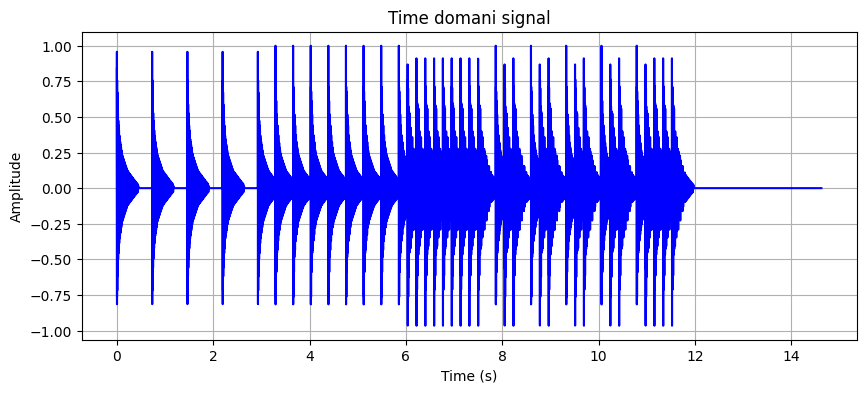

In [8]:
track_path = "../res/originals/8.wav"
sample_rate, track_data = wavfile.read(track_path)

# Convert stereo audio to mono
if track_data.ndim > 1:
    track_data = track_data.mean(axis=1)

# Normalize the audio data
track_data = track_data.astype(np.float32) / np.max(np.abs(track_data))

# Create the time axis for the waveform plot
duration = len(track_data) / sample_rate
time_data = np.linspace(0.0, duration, len(track_data))


def crop_track(start, end, time_data, track_data, sample_rate):
    duration = len(time_data) / sample_rate
    if start < 0 or start > end or start > duration or end > duration:
        raise RuntimeError("Start/end should be in range")
    start_idx = int(start * sample_rate)
    end_idx = int(end * sample_rate)
    return (
        time_data[start_idx:end_idx],
        track_data[start_idx:end_idx],
    )


# Plot the time domain signal
plt.figure(figsize=(10, 4))
x_data, y_data = crop_track(0, duration, time_data, track_data, sample_rate)
plt.plot(x_data, y_data, color="b")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time domani signal")
plt.grid(True)
plt.show()

### Periodic nature of music

After we zoom into the signal, we can see that the signal is periodic.
All musical signals have some perceiveable periodicity to them.
This feature can be exploited to determine the frequency of the signal.

It is to be noted that a signal can have multiple periodicities. And often, this is the case.
When you look at a single note produced by an insturment, we can observe that it is not a pure sine wave.
This is because multiples of fundamental frequency is also present in the signal (called overtones)
This is the reason why the signal is not a perfect sine wave.

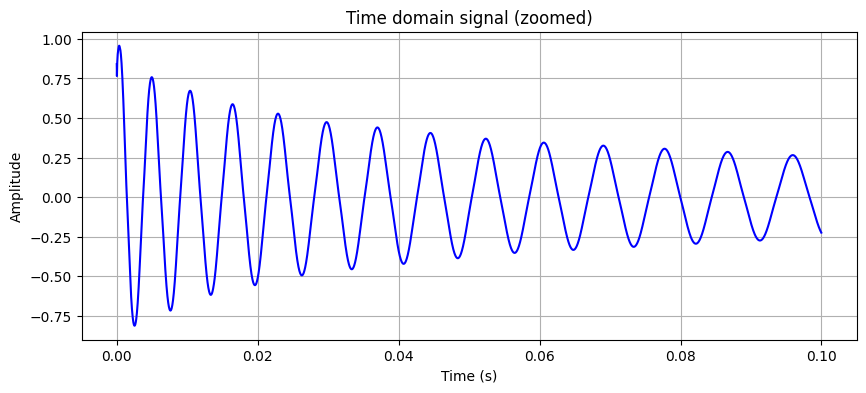

In [9]:

# Plot a small section of the time domain signal
plt.figure(figsize=(10, 4))
x_data, y_data = crop_track(0, 0.1, time_data, track_data, sample_rate)
plt.plot(x_data, y_data, color="b")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time domain signal (zoomed)")
plt.grid(True)
plt.show()

### Autocorrelation

Autocorrelation, sometimes known as serial correlation in the discrete time case, is the correlation of a signal with a delayed copy of itself as a function of delay. This is similar to a cross-correlation operation, which itself is similar to a convolution.


Lets start with the convolution function:

$$c(t) = \int_{-\infty}^{\infty}{f(x) g(t-x) dx}$$

The formula states that a convolution is a mathematical operation on two functions (f and g) that produces a third function (f * g) that expresses how the shape of one is modified by the other.

One of the functions is flipped about the y-axis and offset by a certain amount first. Then the functions are multiplied and integrated over their domains.

For cross-correlation we perform a convolution without flipping the function about the y-axis. Therefore the formula becomes,

$$c(t) = \int_{-\infty}^{\infty}{f(x) g(x-t) dx}$$

Similarly, for autocorrelation we perform cross-correlation with the same function.

Thus, the mathematical formula for autocorrelation is as follows:

$$a(t) = \int_{-\infty}^{\infty}{f(x) f(x - t) dx}$$

For the discrete case, this becomes,

$$a(t) = \sum_{x = 0}^{N}{ f(x)f(x-t)}$$


The figure below illustrates the three functions

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Comparison_convolution_correlation.svg/600px-Comparison_convolution_correlation.svg.png"></center>

### Now, how can we use autocorrelation to figure out the frequency?

Autocorrelation gives you correlation of a signal with its delayed version. When the correlation is high, we can deduce the signal is periodic at that offset.When the correlation is low, the signal is not periodic yet.

Therefore we can figure out the time delta when the signal becomes periodic. This time delta can be used to figure out the frequency of the signal.

#### Limitations

A naive implementation of autocorrelation that selects the first instance of periodicity, will always prefer higher octaves. Since higher frequencies show their periodic nature faster. This is also known as "octave-error" which is a common limitation of autocorrelation. This can be circumvented partly. We can switch to the frequency domain, and look at the frequency with highest intensity. Similarly, we can simply filter improbable notes which are too high to sing/play. It is also possible to not select the first instance of periodicity, but instead select the most probable one.

In [10]:
def detect_note(t, lookahead = 0.1, partition = 5):
    predicted_pitches = []
    for i in np.arange(0, lookahead, lookahead/partition):
        _, y_data = crop_track(t + i, t + i + lookahead/partition, time_data, track_data, sample_rate)
        peaks, _ = find_peaks(correlate(y_data, y_data, "same"), distance=100)
        diffs = list(map(lambda x: abs(x[1] - x[0]), zip(peaks[:-1], peaks[1:])))
        if len(diffs) > 1:
            variance = statistics.variance(diffs)
            mean = statistics.mean(diffs)
            print(diffs, variance)
            predicted_pitches.append((freq_to_notation(sample_rate / mean), variance))
    
    if predicted_pitches:
        pitches, _variances = zip(*predicted_pitches)
        pitch = statistics.mode(pitches)
        return pitch

import musicalbeeps

skip = 0.1
notes = []
for t in np.arange(0, duration - skip, skip):
    note = detect_note(t, lookahead = skip)
    notes.append((note, skip))

coalesce_notes = []
for note, dt in notes:
    if coalesce_notes and note == coalesce_notes[-1][0]:
        n, t = coalesce_notes[-1]
        coalesce_notes[-1] = (n, t + dt)
    else:
        coalesce_notes.append((note, dt))
print(coalesce_notes)

player = musicalbeeps.Player(volume = 1.0,
                            mute_output = False)
for note, dt in coalesce_notes:
    if note:
        player.play_note(str(note), dt)
    else:
        player.play_note("pause", dt)

[237, 237] 0
[303, 303] 0
[340, 340] 0
[372, 372] 0
[398, 398] 0
[417, 417] 0
[433, 433] 0
[207, 207] 0
[276, 276] 0
[322, 322] 0
[352, 352] 0
[383, 383] 0
[415, 415] 0
[230, 230] 0
[294, 294] 0
[332, 332] 0
[363, 363] 0
[392, 392] 0
[418, 418] 0
[436, 436] 0
[176, 176] 0
[261, 261] 0
[316, 316] 0
[347, 347] 0
[375, 375] 0
[404, 404] 0
[422, 422] 0
[220, 220] 0
[285, 285] 0
[328, 328] 0
[359, 359] 0
[387, 387] 0
[424, 424] 0
[127, 195, 195, 127] 1541
[269, 269] 0
[321, 321] 0
[361, 361] 0
[384, 384] 0
[407, 407] 0
[248, 248] 0
[311, 311] 0
[344, 344] 0
[368, 368] 0
[397, 397] 0
[423, 423] 0
[436, 436] 0
[226, 226] 0
[296, 296] 0
[337, 337] 0
[367, 367] 0
[390, 390] 0
[411, 411] 0
[426, 426] 0
[192, 209, 209, 192] 96
[276, 276] 0
[322, 322] 0
[364, 364] 0
[385, 385] 0
[409, 409] 0
[427, 427] 0
[164, 164] 0
[261, 261] 0
[313, 313] 0
[346, 346] 0
[380, 380] 0
[408, 408] 0
[433, 433] 0
[233, 233] 0
[304, 304] 0
[344, 344] 0
[367, 367] 0
[391, 391] 0
[432, 432] 0
[220, 220, 220] 0
[288, 288

### Spectogram

A spectogram is a 2D representation of a signal. It is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. This is useful for audio analysis because this is a complete description of a signal which contains constituent frequencies at every time interval.


The strength f(A) is represeted in decibels (dB) which is a standard logarithmic scale over amplitude (A). Humans also perceive strength of a audio signal logarithmically.

$$ f(A) = 10 \cdot \log_{10}{A} $$

Lets look at a sample spectogram:

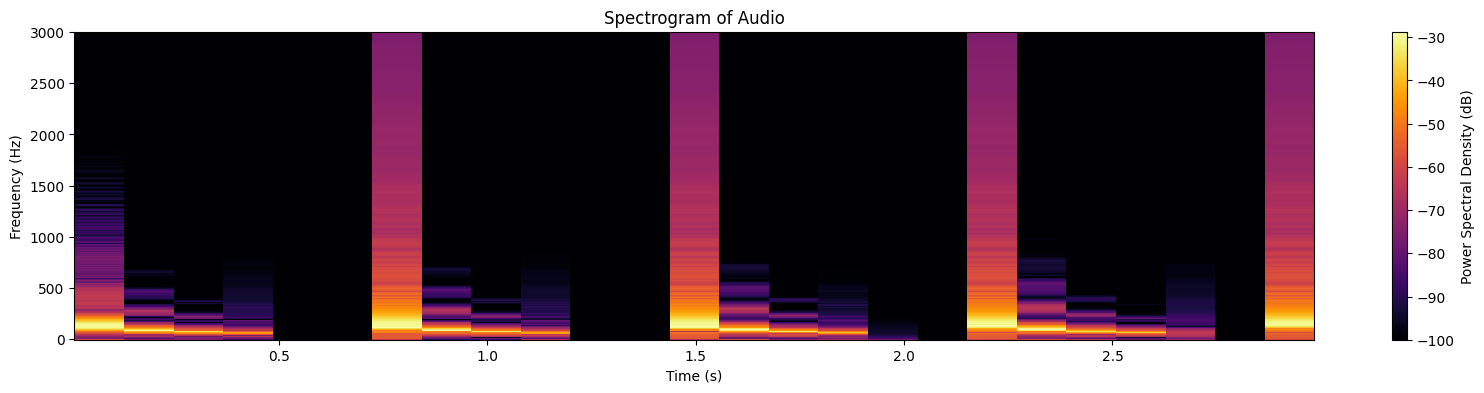

In [11]:

# Compute the spectrogram
nperseg = 6000 # TODO: Figure this out!
frequencies, times, spectrogram_data = spectrogram(track_data, fs=sample_rate, nperseg=nperseg)

# Add a small constant value to the spectrogram data to avoid division by zero
spectrogram_data = np.maximum(spectrogram_data, 1e-10)

def crop_spectogram(start_freq, end_freq, start_time, end_time, frequencies, times, spectrogram_data):
    freq_start_idx = np.searchsorted(frequencies, start_freq)
    freq_end_idx = np.searchsorted(frequencies, end_freq)

    time_start_idx =  np.searchsorted(times, start_time)
    time_end_idx = np.searchsorted(times, end_time)

    f = frequencies[freq_start_idx: freq_end_idx]
    t = times[time_start_idx:time_end_idx]
    s = spectrogram_data[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx]
    return f, t, s 

min_freq = 0
max_freq = frequencies.argmax()
start_time = 0
end_time = 3
cropped_frequencies, cropped_times, cropped_spectogram = crop_spectogram(min_freq, max_freq, start_time, end_time, frequencies, times, spectrogram_data)
log_spectrogram = 10 * np.log10(cropped_spectogram)

# Plot the spectrogram
plt.figure(figsize=(20, 4))
plt.pcolormesh(
    cropped_times, cropped_frequencies, log_spectrogram, shading="auto", cmap="inferno"
)
plt.colorbar(label="Power Spectral Density (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram of Audio")
plt.show()